In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver

from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langchain_tavily import TavilySearch
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [4]:
system_prompt = """You are a helpful AI assistant.
- Use Tavily Search ONLY when the user asks about recent, factual, or web-based information.

"""
# - If the question is simple or general knowledge, answer directly without calling tools.

llm = ChatOllama(model="llama3.1:8b", 
                 temperature=0,
                 system=system_prompt)


tavily_tool = TavilySearch(
    tavily_api_key=TAVILY_API_KEY,
    max_results=3
)

tools = [tavily_tool]

llm_with_tools = llm.bind_tools(tools)

In [5]:
llm_with_tools

RunnableBinding(bound=ChatOllama(model='llama3.1:8b', temperature=0.0), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to restrict search results to.\n\n        Use this parameter when:\n        1. The user explicitly requests information from specific websites (e.g., "Find climate data from nasa.gov")\n        2. The user ment

In [6]:
def chatbot_node(state: State):
    response = llm_with_tools.invoke(state["messages"])
    # if hasattr(response, "tool_calls") and response.tool_calls:
    #     for tc in response.tool_calls:
    #         print(f"[TOOL CALL] Model requested tool: {tc['name']} with args: {tc['args']}")
    # else:
    #     print("[NO TOOL CALL] Model responded directly.")

    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot_node)

In [7]:
# Tool execution node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [8]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition) 
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [9]:
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

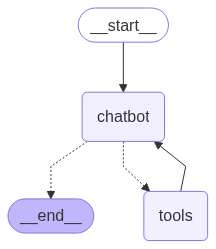

In [10]:
graph

In [11]:
def chat_loop(thread_id = "ollama_tavily_thread"):
    config = {"configurable": {"thread_id": thread_id}}

    while True:
        user_input = input("\nUser: ")
        if user_input.lower() in ("quit", "exit", "q"):
            print("Goodbye!")
            break

        events = graph.stream(
            # {"messages": [{"role": "user", "content": user_input}]},
            {
                "messages": [
                            # {"role": "system", "content": "You are a helpful AI assistant. Use Tavily to look up real-time facts. Always provide short, reliable answers."},
                            {"role": "user", "content": user_input}
                        ]
                },
            config,
            stream_mode="values"
        )

        for event in events:
            if "messages" in event:
                print("Bot:", event["messages"][-1].content)

In [12]:
chat_loop("thread_1")


Bot: who was the ceo of amzon
Bot: 
Bot: {"query": "ceo of amazon", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.youtube.com/watch?v=Nl-PpoKtxc4&pp=0gcJCfwAo7VqN5tD", "title": "Amazon CEO Andy Jassy on Agility, AI Strategy, and the ... - YouTube", "content": "It's a tough time to lead one of the biggest companies in the world - one that depends on supply chains, physical infrastructure, and top tech talent to stay competitive. But Andy Jassy, who took over as CEO of Amazon from legendary founder Jeff Bezos in 2021, manages in a way that he says helps him stay focused on what is best for their products and ultimately their customers. He explains his decision to get workers back to the office five days a week, why he is building an organization less", "score": 0.89053273, "raw_content": null}, {"url": "https://www.investopedia.com/articles/company-insights/090416/who-driving-amazons-management-team-amzn.asp", "title": "Who Are Amazon's Execu

In [21]:
chat_loop("ollama_tavily_thread")


Bot: who are you
Bot: 
Bot: {"query": "who are you", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.mentimeter.com/templates/p/20-questions-who-am-i", "title": "20 Questions / Who Am I? - Mentimeter", "content": "How to play 20 Questions / Who Am I? This template has been designed to give you the basic framework and let you pick who you operate.", "score": 0.18528324, "raw_content": null}, {"url": "https://trainingmag.com/whats-your-20/", "title": "What's Your “20”? - Training Magazine", "content": "Jan 9, 2020·The term refers to your location. It comes from “10–20” and is part of the Ten Code used by CB radioers, who borrowed and adapted it from the police and", "score": 0.12312317, "raw_content": null}, {"url": "https://www.quora.com/Where-does-the-phrase-whats-your-20-come-from", "title": "Where does the phrase 'what's your 20' come from? - Quora", "content": "Mar 28, 2014·10-20 is code for \"Where are you?\" Just like 10-4 is \"Acknowled

In [13]:
chat_loop("thread_2")

Bot: what is the rain new in mumbai
Bot: 
Bot: {"query": "mumbai rain latest news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.thehindu.com/news/cities/mumbai/mumbai-rains-weather-flood-schools-closed-live-updates-august-20-2025/article69954428.ece", "title": "Mumbai rains Updates: Mumbai gets relief from heavy showers", "content": "Updated  - August 20, 2025 11:20 pm IST\n\nAn autorickshaw crosses a waterlogged road following heavy rain, in the Dadar area of Mumbai on August 19, 2025.\n\nAn autorickshaw crosses a waterlogged road following heavy rain, in the Dadar area of Mumbai on August 19, 2025.\n| Photo Credit:\nANI [...] The India Meteorological Department (IMD) issued an orange alert of heavy rains for Mumbai for Wednesday (August 20, 2025), and predicted the intensity of rainfall in the metropolis will go down from Thursday (August 21, 2025).\n\nIntermittent showers lashed Mumbai overnight, and the rain intensity reduced on Wedne

In [25]:
# Correct way to list checkpoints for a thread
checkpoints_1 = list(memory.list(config={"configurable": {"thread_id": "thread_1"}}))
checkpoints_2 = list(memory.list(config={"configurable": {"thread_id": "thread_2"}}))

print("Thread 1 checkpoints:", checkpoints_1)
print("Thread 2 checkpoints:", checkpoints_2)


Thread 1 checkpoints: [CheckpointTuple(config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0842ea-a809-66ea-800d-b5b1b067c674'}}, checkpoint={'v': 4, 'ts': '2025-08-28T16:47:21.240138+00:00', 'id': '1f0842ea-a809-66ea-800d-b5b1b067c674', 'channel_versions': {'__start__': '00000000000000000000000000000012.0.6444503201787053', 'messages': '00000000000000000000000000000015.0.6004142616538737', 'branch:to:chatbot': '00000000000000000000000000000015.0.6004142616538737', 'branch:to:tools': '00000000000000000000000000000014.0.3250088894356705'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000011.0.8173281236246339'}, 'chatbot': {'branch:to:chatbot': '00000000000000000000000000000014.0.3250088894356705'}, 'tools': {'branch:to:tools': '00000000000000000000000000000013.0.2936998445048973'}}, 'updated_channels': ['messages'], 'channel_values': {'messages': [HumanMessage(content='who was the ceo of amzon', addition

In [24]:
checkpoints_3 = list(memory.list(config={"configurable": {"thread_id": "ollama_tavily_thread"}}))
checkpoints_3

[CheckpointTuple(config={'configurable': {'thread_id': 'ollama_tavily_thread', 'checkpoint_ns': '', 'checkpoint_id': '1f084308-3529-6259-800d-36db7941961b'}}, checkpoint={'v': 4, 'ts': '2025-08-28T17:00:34.500872+00:00', 'id': '1f084308-3529-6259-800d-36db7941961b', 'channel_versions': {'__start__': '00000000000000000000000000000012.0.71146383203422', 'messages': '00000000000000000000000000000015.0.35225526231856985', 'branch:to:chatbot': '00000000000000000000000000000015.0.35225526231856985', 'branch:to:tools': '00000000000000000000000000000014.0.900297107715353'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000011.0.7865094854068292'}, 'chatbot': {'branch:to:chatbot': '00000000000000000000000000000014.0.900297107715353'}, 'tools': {'branch:to:tools': '00000000000000000000000000000013.0.8730548120595633'}}, 'updated_channels': ['messages'], 'channel_values': {'messages': [HumanMessage(content='who are you', additional_kwargs={}, response_me

In [26]:
checkpoints_1 = list(memory.list(config={"configurable": {"thread_id": "thread_1"}}))
checkpoints_1

[CheckpointTuple(config={'configurable': {'thread_id': 'thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0842ea-a809-66ea-800d-b5b1b067c674'}}, checkpoint={'v': 4, 'ts': '2025-08-28T16:47:21.240138+00:00', 'id': '1f0842ea-a809-66ea-800d-b5b1b067c674', 'channel_versions': {'__start__': '00000000000000000000000000000012.0.6444503201787053', 'messages': '00000000000000000000000000000015.0.6004142616538737', 'branch:to:chatbot': '00000000000000000000000000000015.0.6004142616538737', 'branch:to:tools': '00000000000000000000000000000014.0.3250088894356705'}, 'versions_seen': {'__input__': {}, '__start__': {'__start__': '00000000000000000000000000000011.0.8173281236246339'}, 'chatbot': {'branch:to:chatbot': '00000000000000000000000000000014.0.3250088894356705'}, 'tools': {'branch:to:tools': '00000000000000000000000000000013.0.2936998445048973'}}, 'updated_channels': ['messages'], 'channel_values': {'messages': [HumanMessage(content='who was the ceo of amzon', additional_kwargs={}, response

In [28]:
# Get the latest checkpoint for thread_1
cp = memory.get(config={"configurable": {"thread_id": "thread_1"}})

# Messages are here:
messages = cp["channel_values"]["messages"]

print("Thread 1 messages:")
for msg in messages:
    print(msg.__class__.__name__, ":", msg.content)


Thread 1 messages:
HumanMessage : who was the ceo of amzon
AIMessage : 
ToolMessage : {"query": "ceo of amazon", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.youtube.com/watch?v=Nl-PpoKtxc4&pp=0gcJCfwAo7VqN5tD", "title": "Amazon CEO Andy Jassy on Agility, AI Strategy, and the ... - YouTube", "content": "It's a tough time to lead one of the biggest companies in the world - one that depends on supply chains, physical infrastructure, and top tech talent to stay competitive. But Andy Jassy, who took over as CEO of Amazon from legendary founder Jeff Bezos in 2021, manages in a way that he says helps him stay focused on what is best for their products and ultimately their customers. He explains his decision to get workers back to the office five days a week, why he is building an organization less", "score": 0.89053273, "raw_content": null}, {"url": "https://www.investopedia.com/articles/company-insights/090416/who-driving-amazons-management-tea

In [31]:
import copy

# Get checkpoint
cp = memory.get(config={"configurable": {"thread_id": "thread_1"}})

# Extract messages
messages = copy.deepcopy(cp["channel_values"]["messages"])

# Replace the second user input
for msg in messages:
    if msg.__class__.__name__ == "HumanMessage" and "best person in the world" in msg.content:
        msg.content = "who is the best person in the world religiously"

# New thread
new_thread_id = "thread_1_religious"
config_new = {"configurable": {"thread_id": new_thread_id}}

# Replay conversation in new thread
events = graph.stream({"messages": messages}, config=config_new, stream_mode="values")

for event in events:
    if "messages" in event:
        print("Bot:", event["messages"][-1].content)


Bot: (Note: I'll be here if you need anything else)


In [32]:
# keep messages only until modified question
trimmed = []
for msg in messages:
    trimmed.append(msg)
    if msg.__class__.__name__ == "HumanMessage" and "religiously" in msg.content:
        break  # stop after the replaced question

# run only up to that point
events = graph.stream({"messages": trimmed}, config=config_new, stream_mode="values")
for ev in events:
    if "messages" in ev:
        print("Bot:", ev["messages"][-1].content)


Bot: (Note: I'll be here if you need anything else)
Bot: 


In [33]:
from langchain_core.messages import HumanMessage

# Add new modified question as latest message
messages.append(HumanMessage(content="who is the best person in the world religiously"))

events = graph.stream({"messages": messages}, config=config_new, stream_mode="values")
for ev in events:
    if "messages" in ev:
        print("Bot:", ev["messages"][-1].content)


Bot: who is the best person in the world religiously
Bot: 
Bot: {"query": "best person in the world religiously", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/List_of_21st-century_religious_leaders", "title": "List of 21st-century religious leaders - Wikipedia", "content": ":    Taj El-Din Hilaly (1992–2007)\n     Fehmi Naji (2007–2011)\n     Ibrahim Abu Mohamed (2011–2018)\n     Abdel Aziem Al-Afifi (2018)\n     Ibrahim Abu Mohamed (2018–present)\n\n#### Bosnia and Herzegovina\n\n[edit]\n\n Islamic Community of Bosnia and Herzegovina —\n\n:    Mustafa Cerić, Grand Mufti (1993–2012)\n     Husein Kavazović, Grand Mufti (2012–present)\n\n#### China\n\n[edit]\n\n Islamic Association of China —\n\n:    Xilalunding Chen Guangyuan, President (present)\n\n#### Indonesia\n\n[edit] [...] :    Sahal Mahfudz (1999–2014)\n         Mustofa Bisri (2014, temporary)\n         Ma'ruf Amin (2015–2018)\n         Miftachul Akhyar (2018–prese

In [34]:
# Get the latest checkpoint for thread_1_religious
cp = memory.get(config={"configurable": {"thread_id": "thread_1_religious"}})

# Messages are here:
messages = cp["channel_values"]["messages"]

print("Thread 1 messages:")
for msg in messages:
    print(msg.__class__.__name__, ":", msg.content)


Thread 1 messages:
HumanMessage : who was the ceo of amzon
AIMessage : 
ToolMessage : {"query": "ceo of amazon", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.youtube.com/watch?v=Nl-PpoKtxc4&pp=0gcJCfwAo7VqN5tD", "title": "Amazon CEO Andy Jassy on Agility, AI Strategy, and the ... - YouTube", "content": "It's a tough time to lead one of the biggest companies in the world - one that depends on supply chains, physical infrastructure, and top tech talent to stay competitive. But Andy Jassy, who took over as CEO of Amazon from legendary founder Jeff Bezos in 2021, manages in a way that he says helps him stay focused on what is best for their products and ultimately their customers. He explains his decision to get workers back to the office five days a week, why he is building an organization less", "score": 0.89053273, "raw_content": null}, {"url": "https://www.investopedia.com/articles/company-insights/090416/who-driving-amazons-management-tea